## Econometric estimation of an IRL-based market portfolio model. Part II: QED

Welcome to your final course project on Advanced Topic RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns (the "QED" model) that is obtained by a generalization of   a model that you analyzed in the previous course
- Respectively, you are expected to re-utilize parts of your previous code from the course project from Course 3: RL (but you can also start from scratch - the template provided here is nearly identical to the one offered to you in course 3)
- Investige the role of non-linearities in price dynamics
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
 

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Estimate the model using the DJI portfolio of 30 stocks, first without signals, and then using simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Explore the implications of calibrated model parameters for default probabilities of stocks in your portfolio. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Experiment with other signals and investigate the impact on model calibration obtained with alternative signals. Present your conclusions and observations. (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis.
For example, you can repeat your analysis for the S&P portfolio.
Or maybe you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. Or anything else.  (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your second IRL based model of market dynamics.
- Develop intuition and understanding about the role of non-linearities in dynamics model. 
- Develop intuition on whether the same model could be calibrated to both equity and credit data.
- Be able to implement trading strategies based on this method.

Let's get started!

## The "Quantum Equlibrium-Disequlibrium" (QED) IRL-based model of stock returns


#### Some personal further notes about the model

In Week 3 lectures of our course we presented the "QED" model
$$
d X_t = \kappa X_t  \left( \frac{\theta}{\kappa} - X_t - \frac{g}{\kappa} X_t^2 \right) dt +  X_t \left( {\bf w} {\bf z}_t \, dt + \sigma d W_t \right)\quad\quad\quad(1)
$$

The associated Kolmogorov forward equation in log-space provides an equivalent probabilistic description of dynamics in terms of the probability distribution and is given by :

$$\frac{ \partial P(y,t|y_0)}{\partial t} = \frac{ \partial }{\partial y}\big[\frac{ \partial V }{\partial y}P(y,t|y_0)\big] + \frac{\sigma^2}{2}\frac{ \partial^2 }{\partial y^2}\big[P(y,t|y_0)\big]$$ 

where $P$ is the density probability distribution of $Y_t=log(X_t)$ and $V(y)  \equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right) y  + \kappa e^y + \frac{1}{2} g e^{2y}$

Applying the Itô formula to $Y_t=log(X_t)$ gives :

$$dY_t = d(log(X_t)) = \frac{1}{X_t}dX_t - \frac{\sigma^2}{2}\frac{1}{X_t^2}dt$$

Replacing $dX_t$ with the equation $(1)$ leads to the following Langevin dynamics for the log-price which will be used for the calibration :

$$d y_t = - \frac{ \partial V(y)}{\partial y} dt + \sigma dW_t$$

In this project, We will explore calibration of this model to market data.
As in the course project for course 3 you analyzed the same model in the limit $ g = 0 $, We would be able to re-utilize parts of your previous code in this project).



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

/Users/pascal/.virtualenvs/deeplearning/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [4]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [5]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

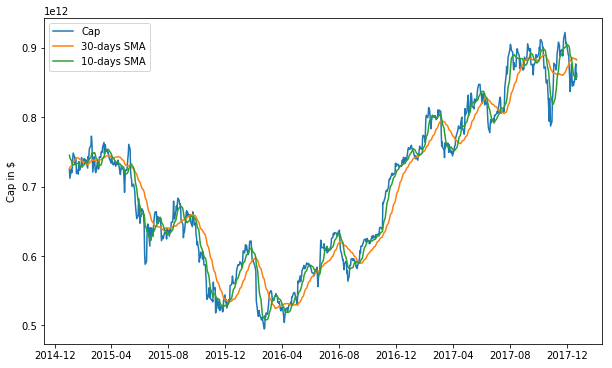

In [7]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with or without moving average signals (Max 10 points)

To calibrate the model, it is convenient to use the log-prices instead of prices. Diffusion in the log-space 
$ y = \log x $ is given by the following Langevin equation:

$$
d y_t = - \frac{ \partial V(y)}{\partial y} dt + \sigma dW_t , \; \; \;  V(y)  \equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right) y  + \kappa e^y + \frac{1}{2} g e^{2y}
$$

where $ W_t $ is a standard Brownian motion.
In terms of variables $ y = \log x $, the negative log-likelihood of data is therefore

$$
LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ 2 \pi  \sigma^2}  } 
\exp \left\{  - \frac{1}{2 \sigma^2} \left(   \frac{ y_{t+ \Delta t} -   y_{t}}{ \Delta t} +  \frac{ \partial V(y)}{\partial y}   
\right)^2
\right\} , 
$$ 

where $ {\bf y}_t  = \log x_t $  now stands for observed values of log-cap. Note that because the model is Markov, the product over $ t = 0, \ldots, T-1 $ does not 
necessarily mean a product of transitions along the same trajectory. The negative log-likelihood should be minimized to estimate parameters $ 
\theta $, $ \sigma $, $ \kappa $, $ g $ and  $ {\bf w} $. You can try to estimate the model first without signals, then with signals.


### Some reformulations

Rewritting the Log likelihood function gives :
$$
LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ 2 \pi  \sigma^2}  } 
\exp \left\{  - \frac{1}{2 \sigma^2} \left(   \frac{ y_{t+ \Delta t} -   y_{t}}{ \Delta t} - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right)   + \kappa e^y + g e^{2y}   
\right)^2
\right\}
$$ 
Equivalent to (with possible regularization terms ) :

$$
LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ 2 \pi  \sigma^2}  } 
\exp \left\{  - \frac{1}{2 \sigma^2} \left(   \frac{1}{ \Delta t} log(\frac{x_{t+ \Delta t}}{x_{t}}) - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right)   + \kappa x + gx^2   
\right)^2 + \lambda_1|{\bf w}^t{\bf 1}-1|^2 + \lambda_2 max(y_t - y_0, 0) + ...
\right\}
$$ 

Here we impose (as it is mentionned in the articel) a regularization term $\lambda_2 max(y_t - y_0, 0)$ that ensures the presence of a barrier between a ’diffusive’ and ’default’ regions of stock log-cap value, where $y_t$ is closed to the argmin of potential V and $y_0$ is the first return.


The above formulas are established for a single stocks. We can also consider the log-likelihood function for all stock simultaneously like in project of course 3. Then defining 

$$  LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ (2 \pi)^{N}  \left| \Sigma_x \right| }} 
\exp \left\{ - \frac{1}{2} \left(   {\bf v}_t
 \right)^{T} 
\Sigma_x^{-1}  
\left(  {\bf v}_t \right)\right\} $$

where

$$  {\bf v}_t \equiv \frac{ y_{t+ \Delta t} -   y_{t}}{ \Delta t} +  \frac{ \partial V(y)}{\partial y}  $$

with $V$, $\kappa$, $\theta$ and $g$ are vectors of different $\kappa_i$, $\theta_i$ $g_i$ of each stock, $\Sigma_x = diag(\sigma_i^2) + \alpha I$ is the regularized covariance matrix assuming pairs independance in noise terms between stocks 

### Data pre-processing and some analysis

In [6]:
print("len df_caps ..:" + str(len(df_cap)))
print("len df_caps without NA ..:" + str(len(df_cap.dropna())))

#data cleaning
long_rolling = long_rolling.dropna()
short_rolling = short_rolling.dropna()
print("long rolling start...:" + str(long_rolling.index[0]))
df_cap = df_cap.loc[df_cap.index >= long_rolling.index[0]]
short_rolling = short_rolling.loc[short_rolling.index >= long_rolling.index[0]]

print(len(df_cap))
print(len(short_rolling))
print(len(long_rolling))

len df_caps ..:2080
len df_caps without NA ..:2080
long rolling start...:2010-02-12 00:00:00
2051
2051
2051


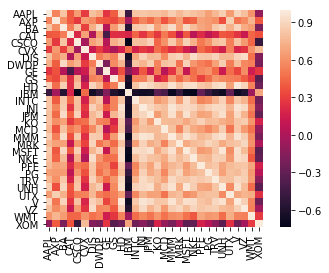

In [7]:
#compute an overview of data correlations
import seaborn as sns
corr = df_cap.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            #annot = True,
           square = True)
#plt.matshow(df_cap.corr())
plt.show()



mean of AAPL returns..:0.000718439906718
var of AAPL returns..:0.0159012803787
.............................
mean of IBM returns..:-0.000102300185654
var of IBM returns..:0.0124070320703
.............................
anual volatility of AAPL...:0.504779558808
growth of AAPL...:0.127404041179
.............................
anual volatility of IBM...:0.393856093686
growth of IBM...:0.0775609069181


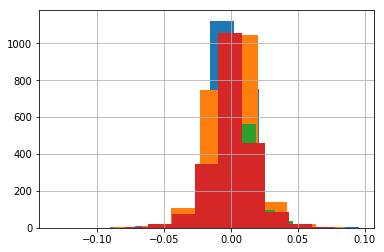

In [6]:
#plot log return and some stitistics for some stocks
columns = ['AAPL', 'IBM', 'CVX', 'CAT']
df_log_returns = pd.DataFrame([], index = df_cap.index[1:], columns = columns )
for c in columns:
    df_log_returns[c] = np.log(np.divide(df_cap[c].values[1:],df_cap[c].values[:-1] ))

nb_of_years = (df_cap.index[-1] -  df_cap.index[0]).days/365
    
print("mean of AAPL returns..:" + str(df_log_returns['AAPL'].mean()))
print("var of AAPL returns..:" + str(df_log_returns['AAPL'].std()))
print(".............................")
print("mean of IBM returns..:" + str(df_log_returns['IBM'].mean()))
print("var of IBM returns..:" + str(df_log_returns['IBM'].std()))
print(".............................")
print("anual volatility of AAPL...:" + str(df_log_returns['AAPL'].std()/(nb_of_years/253)) )
print("growth of AAPL...:" + str(df_log_returns['AAPL'].mean()/253 + 0.5*(df_log_returns['AAPL'].std()/(nb_of_years/253))**2) )
print(".............................")
print("anual volatility of IBM...:" + str(df_log_returns['IBM'].std()/(nb_of_years/253)) )
print("growth of IBM...:" + str(df_log_returns['IBM'].mean()/253 + 0.5*(df_log_returns['IBM'].std()/(nb_of_years/253))**2) )

df_log_returns['IBM'].hist()
df_log_returns['AAPL'].hist()
df_log_returns['CVX'].hist()
df_log_returns['CAT'].hist()
plt.show()

### Define our optimization routine

**Notes:** 
- Three optimization schemes are implemented : two for a single stock with and without signals and an other for all stocks simultaneously
- In this project, we will focuse our analysis mainly on single stock calibration at once but multi stock calibration simultaneously will also be computed with moving average signals 

In [13]:
#optimization function for a single stocks without signals
def fit_MLE_withoutSign(input_data, nb_iter, learning_rate = 0.001):
    
    x_data = input_data
    
    tf.reset_default_graph()
    
    nb_timestep = x_data.shape[0]  # number of time steps


    #define placeholder
    x   = tf.placeholder(shape=(nb_timestep,),dtype=tf.float32,name="x")


    # initialize variables
    kappa = tf.get_variable("kappa",initializer=tf.random_uniform([1],minval=0.,maxval=1.0))
    theta = tf.get_variable("theta",initializer=tf.random_uniform([1],minval=0.,maxval=1.0))
    sigma = tf.get_variable("sigma",initializer=tf.random_uniform([1],minval=0.,maxval=1.0))
    g = tf.get_variable("g",initializer=tf.random_uniform([1],minval=0.,maxval=1.0))
    
    #constraint on parameters
    negativetheta = theta.assign(tf.minimum(-0.001,theta)) #locating the negative theta
    negkappa = kappa.assign(tf.minimum(-0.001,kappa))  #locating the negative kappa
    positiveg   = g.assign(tf.maximum(0.001,g)) #locating the positive g
    posisigma = sigma.assign(tf.maximum(0.001,sigma)) #locating the positive sigma
    #posw2 = w2.assign(tf.maximum(0., w2))
    #posw1 = w1.assign(tf.maximum(0., w1))

    negativelocated = tf.group(positiveg,posisigma,negkappa,negativetheta) #grouping the variables

    
    #compute v
    v = tf.log(tf.divide(x[1:],x[:-1])) - ((theta - 0.5*tf.square(sigma)  \
                                               )*tf.ones([nb_timestep]) + \
                                               kappa*x + g*tf.square(x))[1:]
    #compute log-likelihood to be minimized
    #dist = tf.contrib.distributions.MultivariateNormalDiag(loc=tf.zeros([1]), scale_diag=sigma)
    dist = tf.contrib.distributions.Normal(loc=0., scale=sigma)
    log_prob = dist.log_prob(v) 
    log_likelihood = -tf.reduce_sum(log_prob) 
    #print(log_prob)       
                                               
    #define optimizer                                           
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    min_train = optimizer.minimize(log_likelihood)

                                               
    with tf.Session() as sess:

        # initialize
        sess.run(tf.global_variables_initializer())
        
        loss_values = []
        loss = sess.run(log_likelihood, feed_dict={x: x_data})
        loss_values.append(loss)

        for i in range(nb_iter):

            sess.run(min_train, feed_dict={x: x_data})
            #run constraints
            sess.run(negativelocated)
            # update loss
            new_loss = sess.run(log_likelihood, feed_dict={x: x_data})

            loss_values.append(new_loss)
        
        results = pd.DataFrame([], index = None, columns = ['stock','kappa','theta', 'sigma','g' ])
        results['stock'] = ['']
        results['kappa'] = sess.run(kappa)
        results['theta'] = sess.run(theta)
        results['sigma'] = sess.run(sigma)
        results['g'] = sess.run(g)
    
    
    return results, loss_values


#optimization function for a single stocks with signals
def fit_MLE(input_data, nb_iter, learning_rate = 0.1, reg = 0.1):
    
    x_data, signal_1, signal_2 = input_data
    
    tf.reset_default_graph()
    
    nb_timestep = x_data.shape[0]  # number of time steps


    #define placeholder
    x   = tf.placeholder(shape=(nb_timestep,),dtype=tf.float32,name="x")
    z1  = tf.placeholder(shape=(nb_timestep,),dtype=tf.float32,name="z1") 
    z2  = tf.placeholder(shape=(nb_timestep,),dtype=tf.float32,name="z2") 

    # initialize variables
    kappa = tf.get_variable("kappa",initializer=tf.random_uniform([1],minval=0.,maxval=1.0))
    theta = tf.get_variable("theta",initializer=tf.random_uniform([1],minval=0.,maxval=1.0))
    sigma = tf.get_variable("sigma",initializer=tf.random_uniform([1],minval=0.,maxval=1.0))
    g = tf.get_variable("g",initializer=tf.random_uniform([1],minval=0.,maxval=1.0))
    init = tf.random_normal([1],mean=0.5,stddev=0.1)
    w1 = tf.get_variable("w1",initializer=init)
    w2 = tf.get_variable("w2",initializer=1- init) 
    
    #constraint on parameters
    negativetheta = theta.assign(tf.minimum(-0.001,theta)) #locating the negative theta
    negkappa = kappa.assign(tf.minimum(-0.001,kappa))  #locating the negative kappa
    positiveg   = g.assign(tf.maximum(0.001,g)) #locating the positive g
    posisigma = sigma.assign(tf.maximum(0.001,sigma)) #locating the positive sigma
    posw2 = w2.assign(tf.maximum(0., w2))
    posw1 = w1.assign(tf.maximum(0., w1))

    negativelocated = tf.group(positiveg,posisigma,negkappa,negativetheta, posw1, posw2) #grouping the variables

    
    #compute v
    v = tf.log(tf.divide(x[1:],x[:-1])) - ((theta - 0.5*tf.square(sigma) + \
                                               tf.add(w1*z1,w2*z2))*tf.ones([nb_timestep]) + \
                                               kappa*x + g*tf.square(x))[:-1]
    #compute log-likelihood to be minimized
    #dist = tf.contrib.distributions.MultivariateNormalDiag(loc=tf.zeros([1]), scale_diag=sigma)
    dist = tf.contrib.distributions.Normal(loc=0., scale=sigma)
    log_prob = dist.log_prob(v)
    regularization = tf.reduce_sum(tf.square(w1+w2-1)) 
    log_likelihood = -tf.reduce_sum(log_prob) + reg*regularization
    #print(log_prob)       
                                               
    #define optimizer                                           
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    min_train = optimizer.minimize(log_likelihood)

                                               
    with tf.Session() as sess:

        # initialize
        sess.run(tf.global_variables_initializer())
        
        loss_values = []
        loss = sess.run(log_likelihood, feed_dict={x: x_data, z1 : signal_1, z2: signal_2})
        loss_values.append(loss)

        for i in range(nb_iter):

            sess.run(min_train, feed_dict={x: x_data, z1 : signal_1, z2: signal_2})
            #run constraints
            sess.run(negativelocated)
            # update loss
            new_loss = sess.run(log_likelihood, feed_dict={x: x_data, z1 : signal_1, z2: signal_2})

            loss_values.append(new_loss)
        
        results = pd.DataFrame([], index = None, columns = ['stock','kappa','theta', 'sigma','g', 'w1', 'w2' ])
        results['stock'] = ['']
        results['kappa'] = sess.run(kappa)
        results['theta'] = sess.run(theta)
        results['sigma'] = sess.run(sigma)
        results['g'] = sess.run(g)
        results['w1'] = sess.run(w1)
        results['w2'] = sess.run(w2)
    
    
    return results, loss_values


#optimization function for several stocks
def fit_multi_MLE(input_data, nb_iter, learning_rate = 0.1, reg_w = 0.1, reg_sigma = 0.1):
    
    x_data, signal_1, signal_2 = input_data
    
    tf.reset_default_graph()
    
    nb_timestep = x_data.shape[0]  # number of time steps
    nb_st = x_data.shape[1]  # number of assets

    #define placeholder
    x   = tf.placeholder(shape=(nb_timestep,nb_st),dtype=tf.float32,name="x")
    z1  = tf.placeholder(shape=(nb_timestep,nb_st),dtype=tf.float32,name="z1") 
    z2  = tf.placeholder(shape=(nb_timestep,nb_st),dtype=tf.float32,name="z2") 

    # initialize variables
    kappa =tf.multiply(tf.transpose((tf.ones([nb_st,nb_timestep]))), tf.get_variable("kappa",initializer=tf.random_uniform([nb_st],minval=0.,maxval=1.0)))
    theta =tf.multiply(tf.transpose((tf.ones([nb_st,nb_timestep]))), tf.get_variable("theta",initializer=tf.random_uniform([nb_st],minval=0.,maxval=1.0)))
    sigma_val = tf.get_variable("sigma",initializer=tf.random_uniform([nb_st],minval=0.,maxval=1.0))
    sigma_val_reg = sigma_val + reg_sigma*tf.ones([nb_st])
    sigma =tf.multiply(tf.transpose((tf.ones([nb_st,nb_timestep]))), sigma_val)#sigma_val_reg
    g =tf.multiply(tf.transpose((tf.ones([nb_st,nb_timestep]))), tf.get_variable("g",initializer=tf.random_uniform([nb_st],minval=0.,maxval=1.0)))
    w1 =tf.multiply(tf.transpose((tf.ones([nb_st,nb_timestep]))), tf.get_variable("w1",initializer=tf.random_normal([nb_st],mean=0.5,stddev=0.1)))
    w2 =tf.multiply(tf.transpose((tf.ones([nb_st,nb_timestep]))), tf.get_variable("w2",initializer=tf.random_normal([nb_st],mean=0.5,stddev=0.1)))

    #constraint on parameters
    negativetheta = tf.minimum(-0.001,theta) #locating the negative theta
    negkappa = kappa.assign(tf.minimum(-0.001,kappa))  #locating the negative kappa
    positiveg   = g.assign(tf.maximum(0.001,g)) #locating the positive g
    posisigma = sigma.assign(tf.maximum(0.001,sigma)) #locating the positive sigma
    posw2 = w2.assign(tf.maximum(0., w2))
    posw1 = w1.assign(tf.maximum(0., w1))

    print(kappa.shape)
    #compute v
    v = tf.log(tf.divide(x[1:,:],x[:-1,:])) - ((theta - 0.5*tf.square(sigma) + \
                                               tf.add(tf.ones([nb_timestep,nb_st]),tf.add(tf.multiply(w1,z1),tf.multiply(w2,z2)))) + \
                                               tf.multiply(kappa,x) + tf.multiply(g,tf.square(x)))[1:,:]
    
    #compute log-likelihood to be minimized
    dist = tf.contrib.distributions.MultivariateNormalDiag(loc=tf.zeros([nb_st]), scale_diag=sigma_val_reg)
    #dist = tf.contrib.distributions.Normal(loc=0., scale=sigma)
    log_prob = dist.log_prob(v)
    regularization =tf.reduce_sum(tf.square(w1[0,:]+w2[0,:]-1)) # tf.reduce_sum(tf.square(w1+w2-1))   
    log_likelihood = -tf.reduce_sum(log_prob) + reg_w*regularization 
    #print(log_prob)       
                                               
    #define optimizer                                           
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    min_train = optimizer.minimize(log_likelihood)

                                               
    with tf.Session() as sess:

        # initialize
        sess.run(tf.global_variables_initializer())
        
        loss_values = []
        loss = sess.run(log_likelihood, feed_dict={x: x_data, z1 : signal_1, z2: signal_2})
        loss_values.append(loss)

        for i in range(nb_iter):
            #run optim
            sess.run(min_train, feed_dict={x: x_data, z1 : signal_1, z2: signal_2})
            #run constraints
            sess.run(negativelocated)
            # update loss
            new_loss = sess.run(log_likelihood, feed_dict={x: x_data, z1 : signal_1, z2: signal_2})

            loss_values.append(new_loss)
        
        results = pd.DataFrame([], index = range(nb_st), columns = ['stock','kappa','theta', 'sigma', 'w1', 'w2' ])
        results['stock'] = df_cap.columns
       # print(sess.run(kappa))
        results['kappa'] = sess.run(kappa)[0,:]
        results['g'] = sess.run(g)[0,:]
        results['theta'] = sess.run(theta)[0,:]
        results['sigma'] = sess.run(sigma)[0,:]
        results['w1'] = sess.run(w1)[0,:]
        results['w2'] = sess.run(w2)[0,:]
    
    
    return results, loss_values


### Test for AAPL stock

In [ ]:
#define input data
x = df_cap['AAPL'].values
signal_1 = short_rolling['AAPL'].values
signal_2 = long_rolling['AAPL'].values

#scaling data
x_scaled = x/np.mean(x)
signal_1_scaled = signal_1/np.mean(signal_1)
signal_2_scaled = signal_2/np.mean(signal_2)

#fit model
results, loss_values = fit_MLE([x_scaled, signal_1_scaled, signal_2_scaled], nb_iter = 1000, learning_rate = 0.001, reg = 1)
results['stock'] = 'AAPL'
print("result for AAPL stock................:")
print(results)
plt.plot(loss_values)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('losses')
plt.show()

### Test for IBM stock

In [ ]:
#define input data
x = df_cap['IBM'].values
signal_1 = short_rolling['IBM'].values
signal_2 = long_rolling['IBM'].values

#scaling data
x_scaled = x/np.mean(x)
signal_1_scaled = signal_1/np.mean(signal_1)
signal_2_scaled = signal_2/np.mean(signal_2)

#fit model
results, loss_values = fit_MLE([x_scaled, signal_1_scaled, signal_2_scaled], nb_iter = 1000, learning_rate = 0.001, reg = 0.1)
results['stock'] = 'IBM'
print("result for IBM stock................:")
print(results)
plt.plot(loss_values)
plt.show()

### result for all stocks

#### Using the multi stock minimization function

In [ ]:
#define input data
x = df_cap.values
signal_1 = short_rolling.values
signal_2 = long_rolling.values

#scaling data
x_scaled = x/np.mean(x)
signal_1_scaled = signal_1/np.mean(signal_1)
signal_2_scaled = signal_2/np.mean(signal_2)


results, loss_values = fit_multi_MLE([x_scaled, signal_1_scaled, signal_2_scaled], nb_iter = 100, learning_rate = 0.001, reg_w = 0.1, reg_sigma = 0.1)
print("result for all stocks with multi-stock model.......:")
print(results)


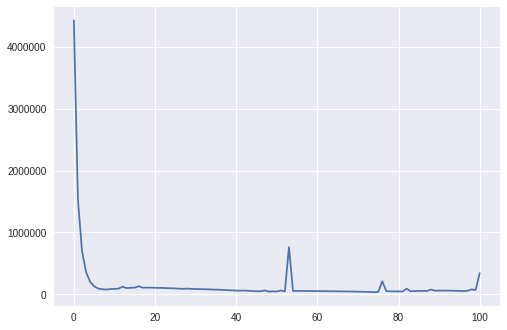

In [75]:
#plot losses curve
plt.plot(loss_values)
plt.show()

#### Using iteration on the single stock minimization model

In [17]:

list_ = []
for c in df_cap.columns:
    print("processing......." + str(c) )
    x_scaled = df_cap[c].values/np.mean(df_cap[c].values)
    signal_1_scaled = short_rolling[c].values/np.mean(short_rolling[c].values)
    signal_2_scaled = long_rolling[c].values/np.mean(long_rolling[c].values)
    #fit model
    results, loss_values = fit_MLE([x_scaled, signal_1_scaled, signal_2_scaled], nb_iter = 1000, learning_rate = 0.001, reg = 0.1)
    list_.append(results)

res = pd.concat(list_)
res['stock'] = df_cap.columns

print("result for all stocks................:")
print(res)

processing.......AAPL
processing.......AXP
processing.......BA
processing.......CAT
processing.......CSCO
processing.......CVX
processing.......DIS
processing.......DWDP
processing.......GE
processing.......GS
processing.......HD
processing.......IBM
processing.......INTC
processing.......JNJ
processing.......JPM
processing.......KO
processing.......MCD
processing.......MMM
processing.......MRK
processing.......MSFT
processing.......NKE
processing.......PFE
processing.......PG
processing.......TRV
processing.......UNH
processing.......UTX
processing.......V
processing.......VZ
processing.......WMT
processing.......XOM
result for all stocks................:
  stock     kappa     theta     sigma         g        w1        w2
0  AAPL -0.382919 -0.135909  0.361635  0.282026  0.078227  0.156301
0   AXP -0.235290 -0.001000  0.016382  0.002416  0.060668  0.173215
0    BA -0.377115 -0.308579  0.561491  0.450766  0.000000  0.254882
0   CAT -0.305222 -0.296425  0.185735  0.317346  0.000702  0.38


## Part 2: Analysis of default rates  (Max 10 point)

For a particle in a potential $ V(y) $ with a metastable minimum $ y = a $ and a barrier with a peak located at $ y = b $, the famous Kramers' escape formula gives the following expression for the escape rate $ r $ (see e.g. the book by van Kampen):

$$ 
r = \frac{\sqrt{ V''(a) \left| V''(b) \right| }}{2 \pi} \exp \left[ - \frac{2}{\sigma^2} (V(b) - V(a) ) \right]
$$

Here $ V''(a) $ and $ V''(b) $ stand for the second derivatives of the potential $ V(y) $ at the minimum and the maximum, respectively. This formula applies as long as the barrier height $ \Delta E \equiv  (V(b) - V(a) \gg \frac{\sigma^2}{2} $. 

Apply the Kramers formula to the QED potential and parameters that you found in your calibration. What range of values of $ r $ do you obtain? Do these values make sense to you? Can you think how you could use the Kramers relation as a way to regularize your MLE calibration?


#### Compute r

Replacing values in the above formula gives the following :

$$ r = \frac{\sqrt{ (\kappa \exp{a} +2g \exp{2a}) \left| (\kappa \exp b +2g \exp{2b}) \right| }}{2 \pi} \exp  \left[ (\theta  \frac{2}{\sigma^2}-1)(b-a) + \frac{2\kappa}{\sigma^2}(\exp{a} - \exp{b}) + \frac{2g}{\sigma^2}(\exp{2a} - \exp{2b})\right]$$

In [43]:
import math
def r(kappa, theta, sigma, g, a, b):
    exp = math.exp((2*theta/sigma**2 - 1)*(b-a) + 2*kappa/sigma**2*(math.exp(a)-math.exp(b)) + 2*g/sigma**2*(math.exp(2*a)-math.exp(2*b)) )
    res = 1/(2*math.pi)*math.sqrt((kappa*math.exp(a)+ 2*g*math.exp(2*a))*abs(kappa*math.exp(a)+ 2*g*math.exp(2*a)))*exp
    return exp

#### Application for somes stock without signals

Potential values for 


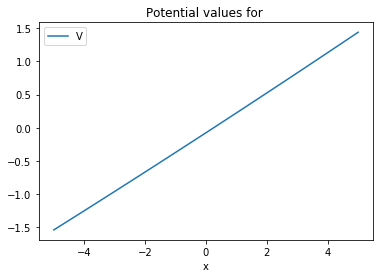

In [18]:
#values estimated for IBM
# kappa     theta     sigma        w1        w2         g
#-0.192144 -0.029526  0.588431  0.273191  0.099073  0.005386

#values for AAPL
#kappa     theta     sigma         g
#0.232636  0.227267 -0.796913 -0.079139

#values for PG
#kappa     theta     sigma        w1        w2         g
#0.388898 -0.434151  0.326202  0.082205  0.036925 -0.107698
for v in range(len(results)): 
    x_values = np.linspace(-5,5,100)
    V =  [((results['theta'][v]  - 0.5*results['sigma'][v]**2  ) - results['kappa'][v] *x  +results['g'][v]*np.square(x)) for x in x_values]

    potential = pd.DataFrame([], index = range(100), columns = ['x', 'V'])
    potential['x'] = x_values
    potential['V'] = V
    potential

    print('Potential values for ' + str(results['stock'][v]))
    potential.plot(x='x', y='V', kind='line', title='Potential values for ' + str(results['stock'][v]))
    plt.show()

## Part 3: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


### Calibration using exponential weighted moving average signal

In this section I will do the same proceedure but setting z2 as exponential weighted moving average. The idea is to give more importance to the closiest value in timespace which should be most reflective of current market conditions. What this signal can also bring is a reduction of the lag in model fitting vs reality due to the use of simple moving average.
Let's try

#### Plot 3 years of data with EWM signal

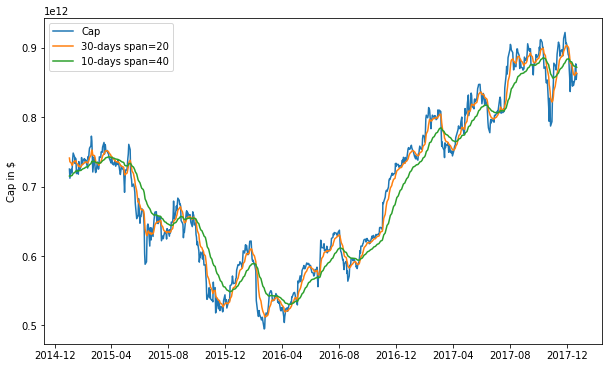

In [12]:
#define ewm
ewm_signal_1 = df_cap.ewm(span=10, adjust=False).mean()
ewm_signal_2 = df_cap.ewm(span=40, adjust=False).mean()

ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(ewm_signal_1.loc[start_date:end_date, :].index, ewm_signal_1.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days span=10' % window_2)
ax.plot(ewm_signal_2.loc[start_date:end_date, :].index, ewm_signal_2.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days span=40' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

#### Data pre-processing

In [16]:

#data cleaning
ewm_signal_1 = ewm_signal_1.dropna()
ewm_signal_2 = ewm_signal_2.dropna()
print(len(ewm_signal_1))
print(len(ewm_signal_2))
print("ewm_signal_1 start...:" + str(ewm_signal_1.index[0]))
print("ewm_signal_2 start...:" + str(ewm_signal_2.index[0]))
print("df_cap start...:" + str(df_cap.index[0]))


2080
2080
ewm_signal_1 start...:2010-01-04 00:00:00
ewm_signal_2 start...:2010-01-04 00:00:00
df_cap start...:2010-01-04 00:00:00


#### Model fitting for AAPL stock

result for AAPL stock................:
  stock     kappa     theta     sigma      g        w1        w2
0  AAPL  0.308124  0.226264  1.082327 -0.004 -0.003595  0.040085


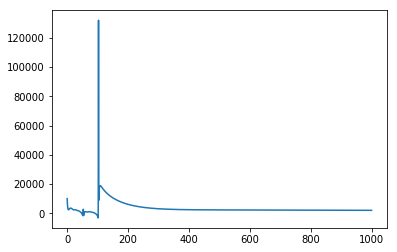

In [20]:
#define input data
x = df_cap['AAPL'].values
signal_1 = ewm_signal_1['AAPL'].values
signal_2 = ewm_signal_2['AAPL'].values

#scaling data
x_scaled = x/np.mean(x)
signal_1_scaled = signal_1/np.mean(signal_1)
signal_2_scaled = signal_2/np.mean(signal_2)

#fit model
results, loss_values = fit_MLE([x_scaled, signal_1_scaled, signal_2_scaled], nb_iter = 1000, learning_rate = 0.1, reg = 1)
results['stock'] = 'AAPL'
print("result for AAPL stock................:")
print(results)
plt.plot(loss_values)
plt.show()

#### For all stocks

In [21]:
#define input data
x = df_cap.values
signal_1 = ewm_signal_1.values
signal_2 = ewm_signal_2.values

#scaling data
x_scaled = x/np.mean(x)
signal_1_scaled = signal_1/np.mean(signal_1)
signal_2_scaled = signal_2/np.mean(signal_2)


results, loss_values = fit_multi_MLE([x_scaled, signal_1_scaled, signal_2_scaled], nb_iter = 100, learning_rate = 0.1, reg_w = 0.1, reg_sigma = 0.1)
print("result for all stocks with multi-stock model.......:")
print(results)

(2080, 30)
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
result for al